In [1]:
import geopandas as gpd
import geocoder
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
import seaborn as sns
from shapely.geometry import Point

In [2]:
#Getting the data from url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))

In [3]:
#First 5 records
data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
#Choosing only data where field Borough doesn't have not assigned value
raw_data_selected = data[data['Borough'] != 'Not assigned']

In [5]:
#Grouping Data
raw_data_selected = raw_data_selected.groupby(['Borough', 'Postal Code'], as_index=False).agg(','.join)

In [6]:
raw_data_selected.head()

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [7]:
#Replacing values in Neighbourhood field with Borough where Neighbourhood is not assigned
raw_data_selected['Neighbourhood'] = np.where(raw_data_selected['Neighbourhood'] == 'Not assigned', raw_data_selected['Borough'], raw_data_selected['Neighbourhood'])

In [8]:
#Shape of Data
raw_data_selected.shape

(103, 3)

## Q2: Use the Geocoder package or the csv file to create the following dataframe?


## So, we are using csv file


In [9]:

geospatial_url = "https://cocl.us/Geospatial_data"
geospatial_data = pd.read_csv(geospatial_url)

In [10]:
geospatial_data.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# Renaming the columns
geospatial_data.columns = ['Postal Code', 'Latitude', 'Longitude']

In [12]:
geospatial_data.columns


Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')

In [13]:
#Merging dataframes
merged_data = pd.merge(raw_data_selected, geospatial_data, on='Postal Code')

In [14]:
merged_data.head()


,Borough,Postal Code,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [15]:
merged_data['Coordinates'] = list(zip(merged_data['Latitude'], merged_data['Longitude']))


In [16]:
merged_data.head()


,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,"(43.6895743, -79.38315990000001)"


In [17]:
merged_data['Coordinates'] = merged_data['Coordinates'].apply(Point)


In [18]:
gdf = gpd.GeoDataFrame(merged_data, geometry='Coordinates')


In [19]:
gdf.head()


,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,POINT (43.72802 -79.38879)
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,POINT (43.71275 -79.39020)
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,POINT (43.71538 -79.40568)
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,POINT (43.70432 -79.38879)
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,POINT (43.68957 -79.38316)


C:\Users\ASUS\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


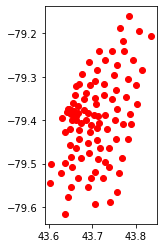

In [20]:
# set up map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='green', edgecolor='black')
# plot and show
gdf.plot(ax=ax, color='red')

plt.show()